In [48]:

import os
import sys
import random
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from scipy.stats import norm
import scipy


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


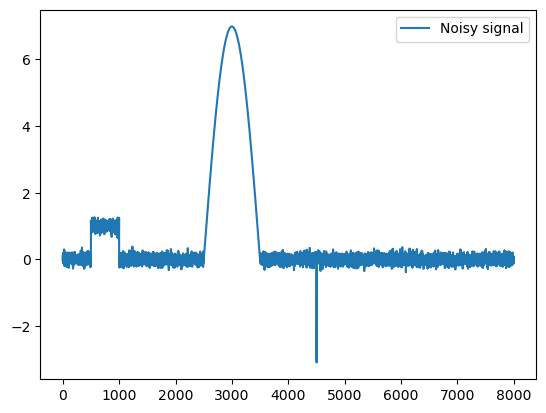

In [49]:
def Generate_TimeSeries(num):
    
    Time_Series = []
    
    n_data = 8000
    base = np.arange(0,0.1,n_data)
    
    sine_amplitude = [ 6, 7, -6, -7]
    impulse_amplitude = [1, 2, 3, -1, -2, -3]
        
    for i in range(num):
                
        noise = np.random.normal(0, 0.1, n_data)
        noisy_signal = base + noise
        
        
        #Step Impulse
        imp_amp = random.choice(impulse_amplitude)
        time_stamp_1 = 500
        impulse = np.zeros(n_data)
        impulse[time_stamp_1] = imp_amp
        noisy_signal = noisy_signal + impulse

        shift_array = np.zeros(8000)
        shift_array[time_stamp_1+1:time_stamp_1+500] = imp_amp
        noisy_signal = noisy_signal + shift_array
        
        
        #Normal Dist
        time_stamp_2 = 2500
        sine_amp = random.choice(sine_amplitude)
        noisy_signal[time_stamp_2:time_stamp_2+1000] = np.zeros(1000) + noisy_signal[time_stamp_2]
        sine_signal = np.zeros(8000)
        sine_signal[time_stamp_2:time_stamp_2+1000] = sine_amp*np.sin(1 * np.arange(0, np.pi, np.pi/1000))
        noisy_signal = noisy_signal + sine_signal
        
        
        #Impulse
        time_stamp_3 = 4500
        impulse = np.zeros(n_data)
        imp_amp = random.choice(impulse_amplitude)
        impulse[time_stamp_3:time_stamp_3+5] = imp_amp
        noisy_signal = noisy_signal + impulse
        
            
        
        Time_Series.append(noisy_signal)
                
        
    return Time_Series


Signals = Generate_TimeSeries(600)
plt.plot(range(len(Signals[0])), Signals[0], label="Noisy signal")
plt.legend()
plt.show()


# Multi Scale CNN-LSTM model

In [50]:
def Prepare_Data_Set_w_Labels(time_series):
    
    X = []
    Y = []
    
    window = 2000
    for series in time_series:
        for i in range(0,len(series),window):
            sub_series = series[i:i+window]
            
            X.append(sub_series)
            if i == 0:
                Y.append([1,0,0,0])
            elif i == 2000:
                Y.append([0,1,0,0])
            elif i == 4000:
                Y.append([0,0,1,0])
            elif i == 6000:
                Y.append([0,0,0,1])
            
    return X,Y


X,Y = Prepare_Data_Set_w_Labels(Signals)
print('X shape',len(X))
print('Y shape',len(Y))

Classes = {}
for clas in Y:
    if str(clas) in Classes.keys():
        Classes[str(clas)] += 1
    else:
        Classes[str(clas)] = 1
print(Classes)

X shape 2400
Y shape 2400
{'[1, 0, 0, 0]': 600, '[0, 1, 0, 0]': 600, '[0, 0, 1, 0]': 600, '[0, 0, 0, 1]': 600}


In [51]:
def scale_conversion_layer(time_series, scales):

    sampled_time_series = []
    for scale in scales:
        sampled_time_series.append(time_series[::scale])

    filtered_time_series = []
    for sampled_time_series in sampled_time_series:
        filtered_time_series.append(np.convolve(sampled_time_series, np.ones(5)/10, mode='same'))

    return filtered_time_series

# Scale_Converter = scale_conversion_layer(np.arange(100), [1,5,10])
# print(Scale_Converter)

In [52]:
def Convert_Input_Multi_Scale(time_series):
    
    Scale_Converter = scale_conversion_layer(time_series[0], [1,5,10])
    Identity = Scale_Converter[0]
    MS_Sample_1 = Scale_Converter[1]
    MS_Sample_2 = Scale_Converter[2]
    
    for series in time_series[1:]:
        Scale_Converter = scale_conversion_layer(series, [1,5,10])
    
        Identity = np.vstack((Identity,Scale_Converter[0]))
        MS_Sample_1 = np.vstack((MS_Sample_1,Scale_Converter[1]))
        MS_Sample_2 = np.vstack((MS_Sample_2,Scale_Converter[2]))
        
    return Identity,MS_Sample_1,MS_Sample_2


**CNN LSTM Model**

A_features (None, 32)
=====
B_features (None, 32)
=====
C_features  (None, 32)
x.shape (None, 96)
====


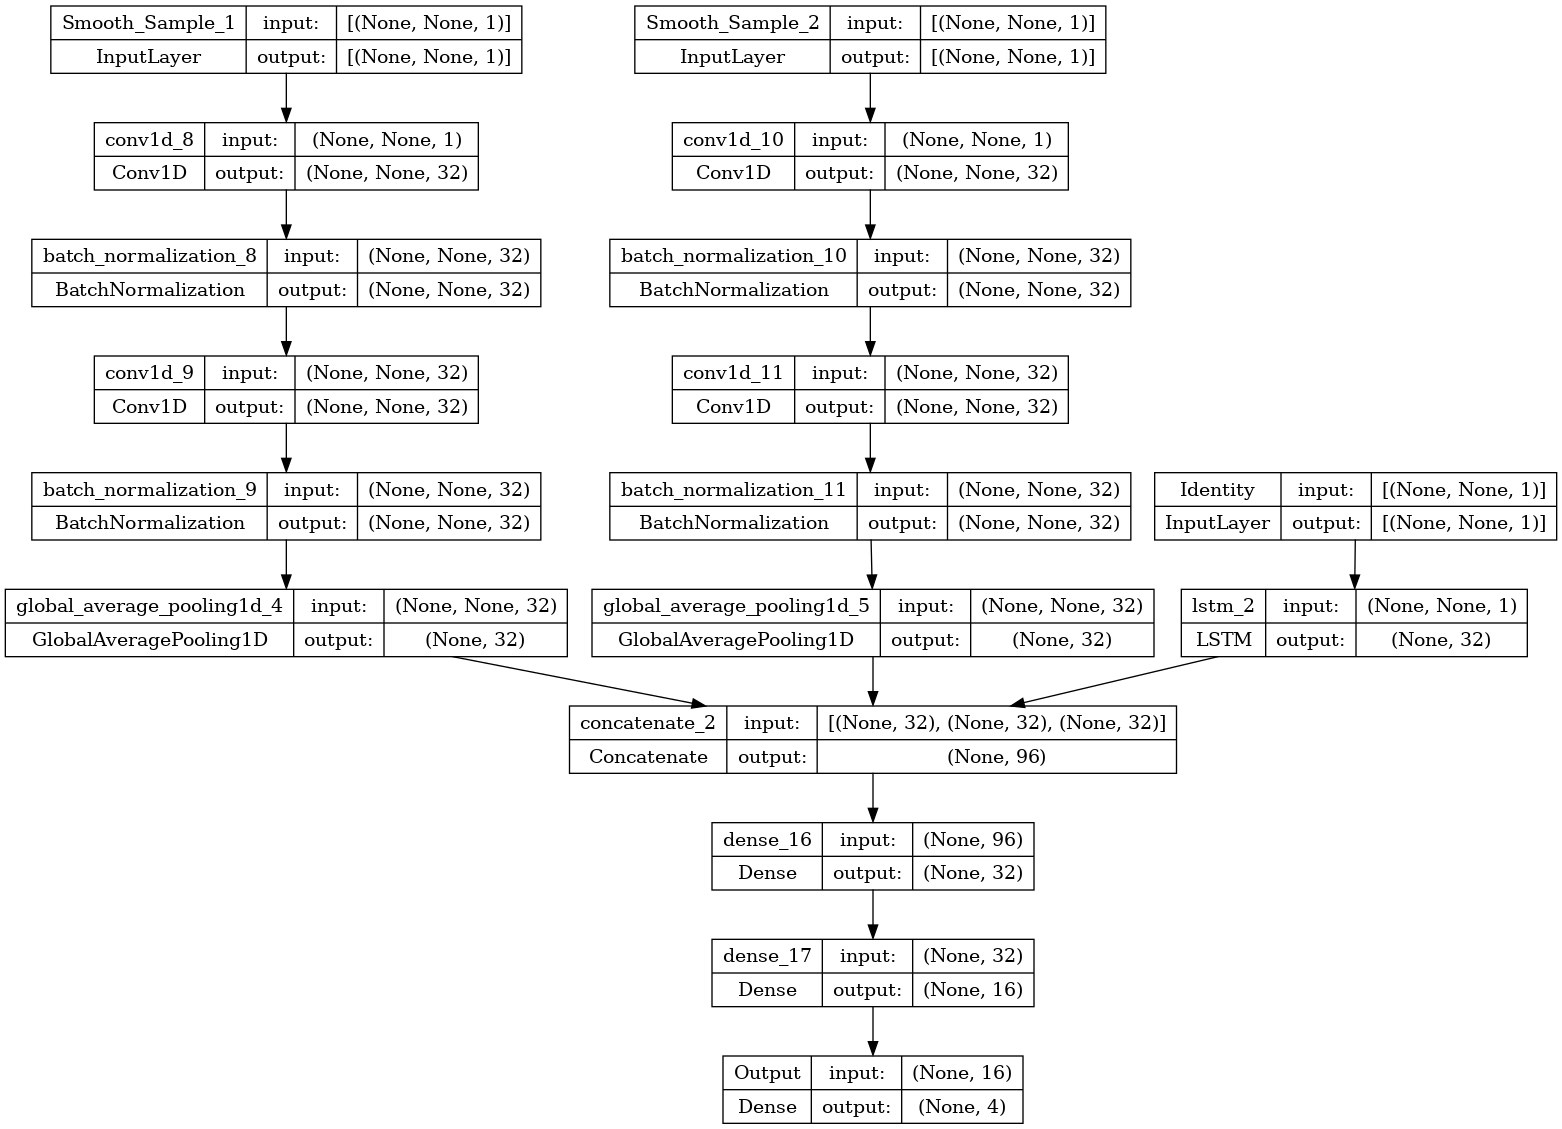

In [53]:
A_input = keras.Input(shape=(None,1,), name="Smooth_Sample_1")  # Variable-length sequence 
B_input = keras.Input(shape=(None,1,), name="Smooth_Sample_2")  # Variable-length sequence 
C_input = keras.Input(shape=(None,1), name="Identity")  


A_features = layers.Conv1D(32,(3,),activation='relu')(A_input)
A_features = layers.BatchNormalization()(A_features)
A_features = layers.Conv1D(32,(3,),activation='relu')(A_features)
A_features = layers.BatchNormalization()(A_features)
A_features = layers.GlobalAveragePooling1D()(A_features)
print('A_features',A_features.shape)
print('=====')

B_features = layers.Conv1D(32,(3,), activation='relu')(B_input)
B_features = layers.BatchNormalization()(B_features)
B_features = layers.Conv1D(32,(3,), activation='relu')(B_features)
B_features = layers.BatchNormalization()(B_features)
B_features = layers.GlobalAveragePooling1D()(B_features)
print('B_features',B_features.shape)
print('=====')

C_features = layers.LSTM(32,dropout=0.2)(C_input)
print('C_features ',C_features.shape)


x = layers.concatenate([A_features, B_features, C_features])
print('x.shape',x.shape)
print('====')

layer_1 = layers.Dense(32,activation='relu')(x)
layer_2 = layers.Dense(16,activation='relu')(layer_1)
final_layer = layers.Dense(4, activation='softmax',name="Output")(layer_2)




# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[A_input, B_input, C_input],outputs=[final_layer])
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'Output': 'categorical_crossentropy'},
              metrics=['acc'])

plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [55]:
X,Y = Prepare_Data_Set_w_Labels(Signals)
print('X shape',len(X))
print('Y shape',len(Y))

Classes = {}
for clas in Y:
    if str(clas) in Classes.keys():
        Classes[str(clas)] += 1
    else:
        Classes[str(clas)] = 1
print(Classes)

Identity,MS_Sample_1,MS_Sample_2 = Convert_Input_Multi_Scale(X)
print('Identity ',Identity.shape)
print('MS Sample 1 ',MS_Sample_1.shape)
print('MS Sample 2 ',MS_Sample_2.shape)

X shape 2400
Y shape 2400
{'[1, 0, 0, 0]': 600, '[0, 1, 0, 0]': 600, '[0, 0, 1, 0]': 600, '[0, 0, 0, 1]': 600}
Identity  (2400, 2000)
MS Sample 1  (2400, 400)
MS Sample 2  (2400, 200)


In [58]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
print('X_train shape',np.array(X_train).shape)

Identity_train,MS_Sample_1_train,MS_Sample_2_train = Convert_Input_Multi_Scale(X_train)

model.fit({'Identity': Identity_train, 'Smooth_Sample_1': MS_Sample_1_train, 'Smooth_Sample_2': MS_Sample_2_train},
          {'Output': np.array(Y_train)},
          epochs=15,
          batch_size=32,
          validation_split=0.1)

X_train shape (1920, 2000)
Epoch 1/15
54/54 [==============================] - 29s 541ms/step - loss: 0.3180 - acc: 0.8466 - val_loss: 1.7182 - val_acc: 0.4635
Epoch 2/15
54/54 [==============================] - 29s 539ms/step - loss: 0.2857 - acc: 0.8571 - val_loss: 0.7892 - val_acc: 0.4688
Epoch 3/15
54/54 [==============================] - 29s 537ms/step - loss: 0.2456 - acc: 0.9074 - val_loss: 0.4572 - val_acc: 0.7292
Epoch 4/15
54/54 [==============================] - 29s 543ms/step - loss: 0.2156 - acc: 0.9086 - val_loss: 0.5483 - val_acc: 0.7812
Epoch 5/15
54/54 [==============================] - 29s 544ms/step - loss: 0.2047 - acc: 0.9161 - val_loss: 0.4147 - val_acc: 0.7760
Epoch 6/15
54/54 [==============================] - 29s 543ms/step - loss: 0.1673 - acc: 0.9404 - val_loss: 1.0312 - val_acc: 0.5833
Epoch 7/15
54/54 [==============================] - 29s 544ms/step - loss: 0.1398 - acc: 0.9531 - val_loss: 0.1249 - val_acc: 0.9479
Epoch 8/15
54/54 [========================

In [59]:
Identity_test,MS_Sample_1_test,MS_Sample_2_test = Convert_Input_Multi_Scale(X_test)

Predictions = model.predict({'Identity': Identity_test, 'Smooth_Sample_1': MS_Sample_1_test, 'Smooth_Sample_2': MS_Sample_2_test})

loss,accuracy = model.evaluate({'Identity': Identity_test, 'Smooth_Sample_1': MS_Sample_1_test, 'Smooth_Sample_2': MS_Sample_2_test},
                             {'Output': np.array(Y_test)})
print("Test loss:", loss)
print("Test accuracy:", accuracy)


15/15 [==============================] - 3s 219ms/step - loss: 1.0170 - acc: 0.7771
Test loss: 1.0169821977615356
Test accuracy: 0.7770833373069763


In [ ]:
# Y_labels_for_CM = []
# Pred_for_CM = []
# for i in range(len(Y_test)):
#     Y_labels_for_CM.append(np.argmax(Y[i]))
#     Pred_for_CM.append(np.argmax(Predictions[i]))
    
# print(Y_labels_for_CM)
# print(Pred_for_CM)

# **Auto Encoder Model**

In [67]:
def construct_probability_distribution(data,new_point,confidence_interval):

    data.sort()
    mean = np.mean(data)
    std = np.std(data)
    
    ci = scipy.stats.norm.interval(confidence_interval, loc=mean, scale=std)
#     print(ci)
#     print(np.min(data))
#     print(new_point)
    
#     plt.plot(data, norm.pdf(data, mean, std))
#     plt.plot([ci[0]]*30,range(0,30,1),'r')
#     plt.plot([ci[1]]*30,range(0,30,1),'r')
#     plt.show()

    if ci[0] < new_point < ci[1]:
        #print('This is Normal point')
        return 1
    else:
        #print('This is an anomaly')
        return 0



def Scatter_Plot_Dist(points,new_point):
    x = points[:,0]
    y = points[:,1]
    plt.scatter(x,y,s=2)
    plt.scatter(new_point[0][0],new_point[0][1],s=5,color = 'r')

    plt.show()

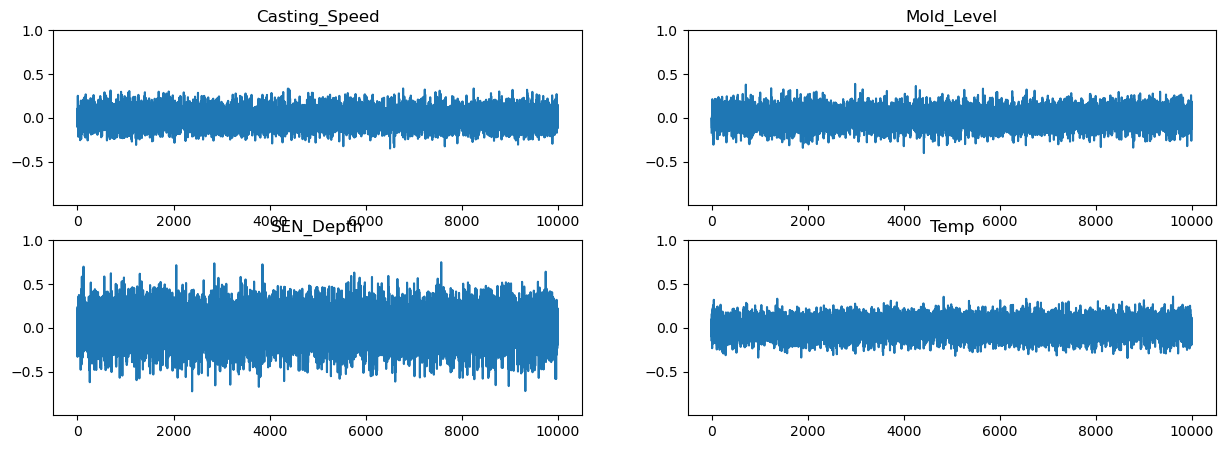

In [61]:
def Generate_Data_For_AutoEncoder_Training():
    
    Casting_Speed = []
    Mold_Level = []
    SEN_Depth = []
    Temp = []
    
    n_data = 10000
    base = np.arange(0,0.1,n_data)
    noise_1 = np.random.normal(0, 0.1, n_data)
    Casting_Speed = base + noise_1
    
    base = np.arange(0,0.1,n_data)
    noise_2 = np.random.normal(0, 0.1, n_data)
    Mold_Level = base + noise_2
    
    base = np.arange(0,0.1,n_data)
    noise_3 = np.random.normal(0, 0.2, n_data)
    SEN_Depth = base + noise_3
    
    base = np.arange(0,0.1,n_data)
    sine = 0.2*np.sin(np.arange(0, 2*np.pi, 2*np.pi/n_data))
    noise_4 = np.random.normal(0, 0.1, n_data)
    Temp = base + noise_4
                
        
    return Casting_Speed, Mold_Level, SEN_Depth, Temp


Casting_Speed, Mold_Level, SEN_Depth, Temp = Generate_Data_For_AutoEncoder_Training()

fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].plot(range(len(Casting_Speed)), Casting_Speed)
axes[0, 0].set_title('Casting_Speed')
axes[0, 0].set_ylim([np.mean(Casting_Speed) - 1,  np.mean(Casting_Speed)+ 1])

axes[0, 1].plot(range(len(Mold_Level)), Mold_Level)
axes[0, 1].set_title('Mold_Level')
axes[0, 1].set_ylim([np.mean(Mold_Level) - 1,  np.mean(Mold_Level)+ 1])

axes[1, 0].plot(range(len(SEN_Depth)), SEN_Depth)
axes[1, 0].set_title('SEN_Depth')
axes[1, 0].set_ylim([np.mean(SEN_Depth) - 1,  np.mean(SEN_Depth)+ 1])

axes[1, 1].plot(range(len(Temp)), Temp)
axes[1, 1].set_title('Temp')
axes[1, 1].set_ylim([np.mean(Temp) - 1,  np.mean(Temp)+ 1])

fig.set_size_inches(15, 5)
plt.show()


In [62]:
def Get_Train_For_AutoEncoder(series):
    
    
    X = [series[0][0],series[1][0],series[2][0],series[3][0]]
    
    for i in range(1,len(series[0])):
        row = [series[0][i],series[1][i],series[2][i],series[3][i]]
        X = np.vstack((X,row))
        
    return X[:9500],X[9501:]

**Auto Encoder Model**

In [63]:
def Get_AutoEncoder_Model():
    Input = keras.Input(shape=(None,1), name="Input")  

    encoder_input = keras.Input(shape=(None, 4), name="Input")
    x = layers.Dense(32,activation='relu')(encoder_input)
    x = layers.Dense(16,activation='relu')(x)
    encoder_output = layers.Dense(2,activation='relu')(x)

    encoder = keras.Model(encoder_input, encoder_output, name="encoder")
    encoder.summary()

    x = layers.Dense(16,activation='relu')(encoder_output)
    x = layers.Dense(32,activation='relu')(x)
    decoder_output = layers.Dense(4,activation='relu')(x)
    
    decoder = keras.Model(encoder_output, decoder_output, name="decoder")
    decoder.summary()

    autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
    autoencoder.summary()
    
    return encoder, decoder, autoencoder


Encoder, Decoder, AutoEncoder = Get_AutoEncoder_Model()

AutoEncoder.compile(metrics=['mse'],
                    loss='mean_squared_error',
                    optimizer='adam')


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 4)]         0         
                                                                 
 dense_18 (Dense)            (None, None, 32)          160       
                                                                 
 dense_19 (Dense)            (None, None, 16)          528       
                                                                 
 dense_20 (Dense)            (None, None, 2)           34        
                                                                 
Total params: 722
Trainable params: 722
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 2

In [70]:
X_train, X_test = Get_Train_For_AutoEncoder([Casting_Speed, Mold_Level, SEN_Depth, Temp])

AutoEncoder.fit(X_train, X_train,
                epochs=5,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose = 0)


train_predictions = AutoEncoder.predict(X_train)
mse_trained = np.mean(np.power(X_train - train_predictions, 2), axis=1)

Encoder_train_output = Encoder.predict(X_train)


297/297 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 21ms/step
[[0.06813768 0.16472675]]


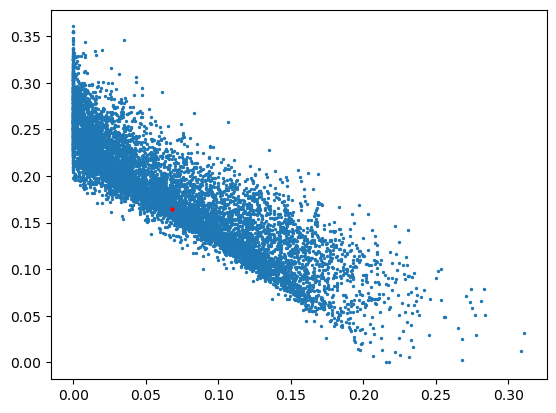

In [71]:
New_point = Encoder.predict(np.array([[0.1,0.02,-0.1,0.01]]))
print(New_point)
Scatter_Plot_Dist(Encoder_train_output,New_point)

1/1 [==============================] - 0s 22ms/step


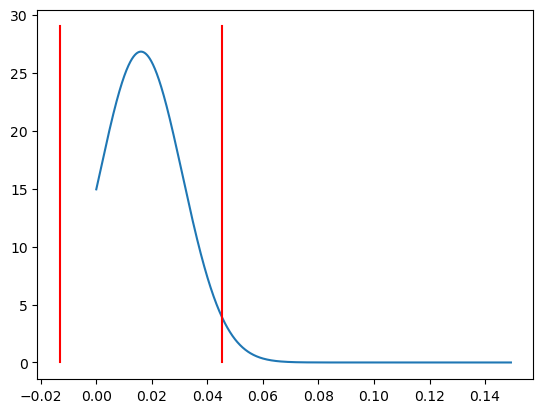

1

In [66]:
new_point = np.array([[0.1,0.02,-0.1,0.01]])
New_Error_Point = AutoEncoder.predict(new_point)
new_mse = np.mean(np.power(new_point - New_Error_Point, 2), axis=1)

construct_probability_distribution(mse,new_mse[0], 0.95)


# Fusion Strategy

In [72]:
def Generate_Data_For_AutoEncoder_Testing():
    
    Casting_Speed = []
    Mold_Level = []
    SEN_Depth = []
    Temp = []
    
    n_data = 20000
    
    impulse = np.zeros(n_data)
    impulse[500:505] = 1
    impulse[4500:4505] = 1
    base = np.arange(0,0.1,n_data)
    noise_1 = np.random.normal(0, 0.1, n_data)
    Casting_Speed = base + noise_1 + impulse
    
    impulse_2 = np.zeros(n_data)
    impulse_2[15000:15005] = 1
    impulse_2[16500:16505] = 1
    base = np.arange(0,0.1,n_data)
    base = np.arange(0,0.1,n_data)
    noise_2 = np.random.normal(0, 0.1, n_data)
    Mold_Level = base + noise_2 + impulse_2
    
    shift_array_1 = np.zeros(n_data)
    shift_array_1[7000:7500] = 1
    shift_array_1[3000:3500] = 2
    base = np.arange(0,0.1,n_data)
    noise_3 = np.random.normal(0, 0.1, n_data)
    SEN_Depth = base + noise_3 + shift_array_1
    
    
    shift_array = np.zeros(n_data)
    shift_array[9000+1:9500] = 1
    shift_array[13000+1:13500] = 1
    shift_array[19000+1:19500] = 2
    base = np.arange(0,0.1,n_data)
    noise_4 = np.random.normal(0, 0.1, n_data)
    Temp = base + noise_4 + shift_array
                
        
    return Casting_Speed, Mold_Level, SEN_Depth, Temp


Casting_Speed_test, Mold_Level_test, SEN_Depth_test, Temp_test = Generate_Data_For_AutoEncoder_Testing()


625/625 [==============================] - 1s 1ms/step


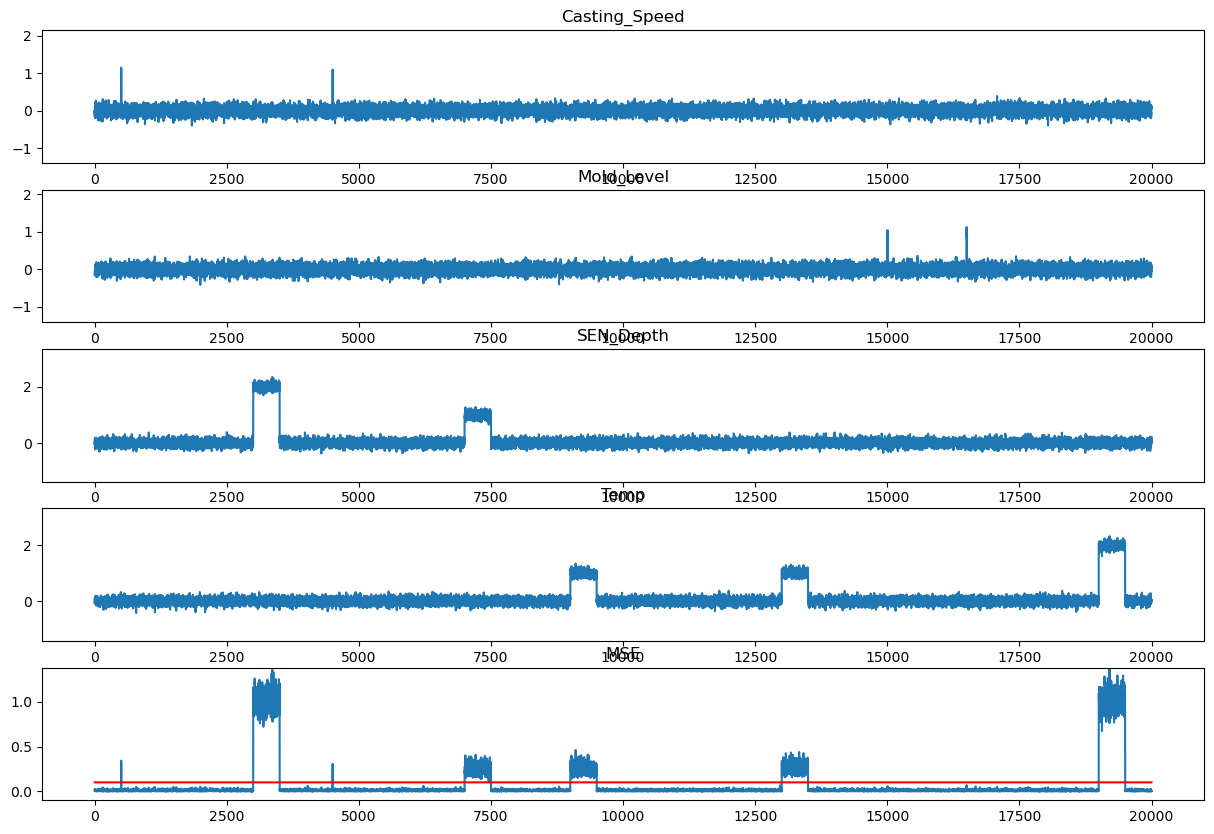

In [77]:
def Get_Test_Data_For_AutoEncoder(series):
    
    X = [series[0][0],series[1][0],series[2][0],series[3][0]]
    
    for i in range(1,len(series[0])):
        row = [series[0][i],series[1][i],series[2][i],series[3][i]]
        X = np.vstack((X,row))
        
    return X

X_test_F = Get_Test_Data_For_AutoEncoder([Casting_Speed_test, Mold_Level_test, SEN_Depth_test, Temp_test])

test_predictions = AutoEncoder.predict(X_test_F)
mse_test = np.mean(np.power(X_test_F - test_predictions, 2), axis=1)

fig, axes = plt.subplots(nrows=5, ncols=1)

axes[0].plot(range(len(Casting_Speed_test)), Casting_Speed_test)
axes[0].set_title('Casting_Speed')
axes[0].set_ylim([np.min(Casting_Speed_test) - 1,  np.max(Casting_Speed_test)+ 1])
# axes[0].xticks(range(0,20000,2000))

axes[1].plot(range(len(Mold_Level_test)), Mold_Level_test)
axes[1].set_title('Mold_Level')
axes[1].set_ylim([np.min(Mold_Level_test) - 1,  np.max(Mold_Level_test)+ 1])
# axes[1].xticks(range(0,20000,2000))

axes[2].plot(range(len(SEN_Depth_test)), SEN_Depth_test)
axes[2].set_title('SEN_Depth')
axes[2].set_ylim([np.min(SEN_Depth_test)-1,  np.max(SEN_Depth_test)+1])
# axes[2].xticks(range(0,20000,2000))

axes[3].plot(range(len(Temp_test)), Temp_test)
axes[3].set_title('Temp')
axes[3].set_ylim([np.min(Temp_test)-1,  np.max(Temp_test)+1])
# axes[3].xticks(range(0,20000,2000))

axes[4].plot(range(len(mse_test)), mse_test)
axes[4].plot(range(len(mse_test)), [0.1]*len(mse_test),'r')
axes[4].set_title('MSE')
axes[4].set_ylim([np.min(mse_test)-0.1,  np.max(mse_test)])
# axes[4].xticks(range(0,20000,2000))

fig.set_size_inches(15, 10)

plt.show()


In [74]:
def Prepare_Data_for_CNN_LSTM(time_series):
    
    X = []
    Y = []
    
    window = 2000
    for count,series in enumerate(time_series):
        for i in range(0,len(series),window):
            sub_series = np.array(series[i:i+window])
            
            
            if count == 0:
                if i in [0,2000,4000]:
                    X.append(sub_series)
                    Y.append([0,0,1,0])
                else:
                    X.append(sub_series)
                    Y.append([0,0,0,1])
            if count == 1:
                if i in [12000,14000,16000]:
                    X.append(sub_series)
                    Y.append([0,0,1,0])

            if count == 2:
                if i in [0, 2000, 4000,6000]:
                    X.append(sub_series)
                    Y.append([1,0,0,0])

            if count == 3:
                if i in [8000,10000, 12000, 18000]:
                    X.append(sub_series)
                    Y.append([1,0,0,0])

                
              
    return X,Y


# X_CNN_LSTM,Y_CNN_LSTM = Prepare_Data_for_CNN_LSTM([Casting_Speed_test, Mold_Level_test, SEN_Depth_test, Temp_test])


# Identity_CNN_LSTM,MS_Sample_1_CNN_LSTM,MS_Sample_2_CNN_LSTM = Convert_Input_Multi_Scale(X_CNN_LSTM)

# Predictions_CNN_LSTM = model.predict({'Identity': Identity_CNN_LSTM, 'Smooth_Sample_1': MS_Sample_1_CNN_LSTM, 'Smooth_Sample_2': MS_Sample_2_CNN_LSTM})

# loss,accuracy = model.evaluate({'Identity': Identity_CNN_LSTM, 'Smooth_Sample_1': MS_Sample_1_CNN_LSTM, 'Smooth_Sample_2': MS_Sample_2_CNN_LSTM},
#                              {'Output': np.array(Y_CNN_LSTM)})
# print("Test accuracy:", accuracy)


In [76]:
def Anomaly_Detection_Fusion_Strategy(Y_CNN_LSTM,Predictions_CNN_LSTM,X_CNN_LSTM,X_test,mse_test,mse):
    
    alpha = [5,3,1,0]
    beta = [1,1.2,0.8,0.5]
    
    window = 2000
    for i in range(0,20000,window):
        ladel = np.array(X_test[i:i+window,:])
#         print(ladel.shape)

        ladel_transpose = ladel.transpose()
#         print(ladel_transpose.shape)
        
        
#         fig, axes = plt.subplots(nrows=4, ncols=1)
#         axes[0].plot(range(len(ladel_transpose[0])), ladel_transpose[0])
#         axes[0].set_ylim([np.min(ladel_transpose[0]) - 1,  np.max(ladel_transpose[0])+ 1])

#         axes[1].plot(range(len(ladel_transpose[1])), ladel_transpose[1])
#         axes[1].set_ylim([np.min(ladel_transpose[1]) - 1,  np.max(ladel_transpose[1])+ 1])

#         axes[2].plot(range(len(ladel_transpose[2])), ladel_transpose[2])
#         axes[2].set_ylim([np.min(ladel_transpose[2])-1,  np.max(ladel_transpose[2])+1])

#         axes[3].plot(range(len(ladel_transpose[3])), ladel_transpose[3])
#         axes[3].set_ylim([np.min(ladel_transpose[3])-1,  np.max(ladel_transpose[3])+1])
        
#         fig.set_size_inches(15, 10)
#         plt.show()
        
        Identity_CNN_LSTM,MS_Sample_1_CNN_LSTM,MS_Sample_2_CNN_LSTM = Convert_Input_Multi_Scale(ladel_transpose)
        Predictions_CNN_LSTM = model.predict({'Identity': Identity_CNN_LSTM, 'Smooth_Sample_1': MS_Sample_1_CNN_LSTM, 'Smooth_Sample_2': MS_Sample_2_CNN_LSTM})
        
        #print(Predictions_CNN_LSTM)
#         print('===')
        
        S_j = []
        cnn_lstm_pred = []
        for pred in Predictions_CNN_LSTM:
            S_j.append(alpha[np.argmax(pred)])
            cnn_lstm_pred.append(np.argmax(pred))
        print('cnn_lstm_pred',cnn_lstm_pred)
#         print('S_j',S_j)
            
        L_outlier = 0
        New_Error_Points = AutoEncoder.predict(ladel,verbose = 0)
        for j in range(len(ladel)):
            new_mse = np.mean(np.power(np.array(ladel[j]) - np.array(New_Error_Points[j]), 2))
            L_outlier += 1 if construct_probability_distribution(mse,new_mse, 0.95) == 0 else 0
            
#         print('L_outlier ',L_outlier)
#         print('len(ladel)',len(ladel))
        S_mul = (L_outlier/len(ladel))*100
#         print('S_mul',S_mul)
        
        
        S_ladel = S_mul + np.sum(np.array(beta)*np.array(S_j))
        print('S_ladel ',S_ladel)
        
        label = ''
        if S_ladel > 3.5:
            label = 1
            print('There is anomaly')
        else:
            print('Normal Process')
        
        
        print('=======')
    
        
        
        
Anomaly_Detection_Fusion_Strategy(Y_CNN_LSTM,Predictions_CNN_LSTM,X_CNN_LSTM,X_test_F,mse_test,mse_trained)

1/1 [==============================] - 0s 167ms/step
cnn_lstm_pred [2, 2, 2, 2]
S_ladel  4.0
There is anomaly
1/1 [==============================] - 0s 161ms/step
cnn_lstm_pred [2, 2, 0, 2]
S_ladel  31.75
There is anomaly
1/1 [==============================] - 0s 166ms/step
cnn_lstm_pred [2, 2, 2, 2]
S_ladel  3.8
There is anomaly
1/1 [==============================] - 0s 170ms/step
cnn_lstm_pred [2, 2, 0, 2]
S_ladel  31.9
There is anomaly
1/1 [==============================] - 0s 170ms/step
cnn_lstm_pred [2, 2, 2, 0]
S_ladel  30.5
There is anomaly
1/1 [==============================] - 0s 158ms/step
cnn_lstm_pred [2, 2, 2, 2]
S_ladel  3.5
Normal Process
1/1 [==============================] - 0s 162ms/step
cnn_lstm_pred [2, 2, 2, 0]
S_ladel  30.55
There is anomaly
1/1 [==============================] - 0s 155ms/step
cnn_lstm_pred [2, 2, 2, 2]
S_ladel  3.6
There is anomaly
1/1 [==============================] - 0s 170ms/step
cnn_lstm_pred [2, 2, 2, 2]
S_ladel  3.75
There is anomaly
1/1 [